# Subducted carbon

Compute how much carbon is subducted from each contribution of:

- Sediment
- Organic Sediment
- Serpentinite
- Crust
- Lithosphere

The previous notebook __01-Sources of Carbon.ipynb__ must be run before this notebook. Output grids for the following carbon components would have been written to a folder called `/Notebook01/Reservoirs/`. These are defined as

```python
carbon_components = ["Sediment", "Crust", "Lithosphere", "Serpentinite", "Organic_Sediments"]
```

### Considerations for sedimentary carbon
Some carbon is __accreted__ to the overriding plate from the sediments

> __Citation__:
> Vannucchi, P., Morgan, J. P., & Balestrieri, M. L. (2016). Subduction erosion, and the de-construction of continental crust: The Central America case and its global implications. Gondwana Research, 40, 184–198. https://doi.org/10.1016/j.gr.2016.10.001

### Considerations for serpentinite carbon
Serpentinisation is related to slab bending and takes carbon into the mantle. We partition 4-15 Mt C/yr (4) to a slab dip of 20-45 degrees, considering average slab dip to be 31 degrees and minimum serpentinisation as 4 Mt C/yr.
We define a linear relationship between serpentinisation (Mt C/yr) and slab dip (degrees) at a subduction segment, with gradient:

$$ \frac{7.5 - 4}{31 - 0} \approx 0.1129$$

Thus, 

$$ C_{\mathrm{seg}} = \frac{0.1129\alpha_{\mathrm{seg}} + 4}{L_0}$$

where $\alpha_{\mathrm{seg}}$ is slab dip at a subduction segment and $L_0$ is the total length of all subduction segments at the present day. We multiply by each segment's subduction convergence to distribute this value of serpentinisation across all global segments.

> __Citations__:
> 1. Vannucchi, P., Morgan, J. P., & Balestrieri, M. L. (2016). Subduction erosion, and the de-construction of continental crust: The Central America case and its global implications. Gondwana Research, 40, 184–198. https://doi.org/10.1016/j.gr.2016.10.001
> 2. Buffett, B. A., & Heuret, A. (2011). Curvature of subducted lithosphere from earthquake locations in the Wadati-Benioff zone. Geochemistry, Geophysics, Geosystems, 12(6), 1–13. https://doi.org/10.1029/2011GC003570
> 3. Faccenda, M., Gerya, T. V., & Burlini, L. (2009). Deep slab hydration induced by bending-related variations in tectonic pressure. Nature Geoscience, 2(11), 790–793. https://doi.org/10.1038/ngeo656
> 4. Kelemen, P. B., & Manning, C. E. (2015). Reevaluating carbon fluxes in subduction zones, what goes down, mostly comes up. Proceedings of the National Academy of Sciences of the United States of America, 112(30), E3997–E4006. https://doi.org/10.1073/pnas.1507889112

In [1]:
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import joblib
import numpy as np
import pygplates
import gplately
import gplately.grids as grids
import gplately.tools as tools
import ptt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
from scipy import ndimage
import pandas as pd
import glob, os
from slabdip import SlabDipper
import numpy.ma as ma
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline
# plt.style.use('ggplot')

#from pygplates_helper import *

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# output grid resolution - should be identical to input grid resolution!
spacingX, spacingY = 0.2, 0.2
resX, resY = int(360./0.2 + 1), int(180./0.2 + 1)
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)
lonq, latq = np.meshgrid(lon_grid,lat_grid)

# reconstruction time steps and spacing
min_time = 0
max_time = 1000
timestep_size = 1

# time array
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)
# reversed (start at max_time, end at min_time)
backward_reconstruction_times = np.arange(max_time, min_time-timestep_size, -timestep_size)




# OUTPUT SAVING TOGGLES
save_output_netcdf = True # !! important
save_output_snapshots = False

# This output is useful for notebook 7
save_cumulative_subducted_carbon = True

# This is to save outputs from the parallelised "carbon_subducted_and_accreted" routine
save_outputs_to_csv = True

### Ensure all needed output paths are created
If output saving toggles are passed as `True`, make sure the save directories exist. 

### Change `folder_name` to keep track of results of Notebook 02 reruns

In [2]:
folder_name = "Muller22_Apr21"

output_directory = os.path.abspath("./Outputs/{}/Notebook02/".format(folder_name))


# --------------- Everything below here can be kept as-is ----------------
# FOR SUBDUCTED CARBON CONTRIBUTIONS PER TIMESTEP
# These are for each time contribution to subducted carbon, as well as the cumulative subducted carbon per time.
output_subducted_carbon_grid_directory = "/subducted_carbon/{}/{}/"
for storage in ['Lithosphere', 'Organic_Sediments', 'Serpentinite', 'Sediment', 'Crust']:
    for quantity in ['min', 'mean', 'max']:
        os.makedirs(
            output_directory + output_subducted_carbon_grid_directory.format(storage, quantity), 
            exist_ok=True
        )
os.makedirs(output_directory+"/csv/".format(folder_name), exist_ok=True)
os.makedirs(output_directory+"/figures/".format(folder_name), exist_ok=True)

A function to define age and spreading rate grids needed for the `SlabDipper` object.

In [3]:
def defineGridFiles():
    
    # Change this: Directories to age grids and spreading rate grids
    grid_directory = "./Muller2022_InputGrids/"
    spreadrate_filename = grid_directory+"SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.1f}Ma.nc"
    agegrid_filename = grid_directory+"SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.1f}Ma.nc"
    
    return agegrid_filename, spreadrate_filename

## Initialise a plate reconstruction model - 2 options

### 1. Define gplately's `PlateReconstruction` and `PlotTopologies` object, then the `SlabDipper` object.

In [ ]:
# Use GPlately's DataServer to get a rotation model, topology features and static polygons
gdownload = gplately.download.DataServer("Muller2022", verbose=True)
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use GPlately's DataServer to get coastlines and continents
coastlines, continents, COBs = gdownload.get_topology_geometries()


### 2. Manually define a local plate model directory
Un-comment this out if needed

In [ ]:
"""
input_directory = "/.../path/to/model/"

# Change the code to point to the rotation filenames
rotation_filenames = [
    
    input_directory+'/optimisation/1000_0_rotfile_Merdith_et_al_Cao_new_ncc_git_20231016_run1.rot',
    input_directory+'/optimisation/Rotation_file_1800_1000_no_ncc_new_SaoFrancisco_git_20231016_run1.rot'
]

rotation_model = pygplates.RotationModel(rotation_filenames)


# Change the code to point to the topology feature filenames
topology_filenames = [
    input_directory+'/250-0_plate_boundaries_Merdith_et_al.gpml',
    input_directory+'/1000-410-Topologies_Merdith_et_al_Cao.gpml',
    input_directory+'/410-250_plate_boundaries_Merdith_et_al.gpml',
    input_directory+'/1800-1000Ma-plate-boundary_new_valid_time_and_subduction_polarity.gpml',
    input_directory+'/1000-410-Transforms_Merdith_et_al_Cao.gpml',
    input_directory+'/TopologyBuildingBlocks_Merdith_et_al.gpml',
    input_directory+'/1000-410-Convergence_Merdith_et_al_Cao.gpml',
    input_directory+'/1000-410-Divergence_Merdith_et_al_Cao.gpml',
    input_directory+'/Proterozoic_Poles.gpml'
]

# KEEP THESE 3 LINES AS-IS
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    topology_features.add( pygplates.FeatureCollection(topology_filename) )
        

# Change the code to point to the continent filename(s)
continents = input_directory+'/shapes_continents_Cao.gpmlz'
"""

### Define `gplately`'s `PlateReconstruction` and `PlotTopologies` objects with the `SlabDipper` object.

In [4]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

time = max_time
gplot = gplately.PlotTopologies(model, time=time, coastlines=coastlines, continents=continents)

# Initialise SlabDipper object, allocate it a spreading rate grid and an age grid
agegrid_filename, spreadrate_filename = defineGridFiles()
dipper = SlabDipper()
dipper._model = model
dipper.set_age_grid_filename(agegrid_filename)
dipper.set_spreading_rate_grid_filename(spreadrate_filename)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [5]:
cell_area = tools.lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

In [6]:
# Register colourmaps
from matplotlib.colors import LinearSegmentedColormap
import os

cmap_dir = "./utils/ScientificColourMaps5/"

def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

subdirs = get_immediate_subdirectories(cmap_dir)

cmap_crameri = dict()
for subdir in subdirs:
    print (subdir)
    cm_data = np.loadtxt(cmap_dir+"{}/{}.txt".format(subdir, subdir))
    cmap_crameri[subdir] = LinearSegmentedColormap.from_list(subdir, cm_data)
    cmap_crameri[subdir+'_r'] = LinearSegmentedColormap.from_list(subdir+'_r', cm_data[::-1])
    plt.register_cmap(cmap=cmap_crameri[subdir])
    plt.register_cmap(cmap=cmap_crameri[subdir+'_r'])

acton
bamako
batlow
berlin
bilbao
broc
buda
cork
davos
devon
grayC
hawaii
imola
lajolla
lapaz
lisbon
nuuk
oleron
oslo
roma
tofino
tokyo
turku
vik


Calculate subducted and accreted carbon from subduction convergence stats and slab dip predictions found with the SlabDipper object's `tessellate_slab_dip` function per timestep. We sample the age of the seafloor using age grids.

In [7]:
def carbon_subducted_and_accreted(
    time, model, 
    tessellation_threshold_radians
):
    
    ######## NOTE: This path relies on the folder structure defined in Notebook 1. 
    # Ensure input_cdf_filename is the same path used to save the carbon grids in Notebook 1.
    input_cdf_filename  = "./Outputs/{}/Notebook01/Reservoirs/{}/{}/carbon_{}_grid_{:04d}.nc"
    
    # Output paths for saving netCDF grids containing all component and quantities' contribution 
    # to the global distribution of subducted carbon at the current timestep (4 components, 3 
    # quantities, so 12 grids per timestep).
    output_cdf_filename = output_directory+"/subducted_carbon/{}/{}/subducted_carbon_{}_{}.nc"

    # The order of components and quantities to loop through. Must be kept as-is.
    carbon_components = ["Sediment", "Crust", "Lithosphere", "Serpentinite", "Organic_Sediments"]
    quantities = ["min", "mean", "max"]

    # Shape is (4, 1, 3) for (components, current time, (min,mean,max))
    carbon_subducted = np.zeros((len(carbon_components), 1, 3))
    carbon_in_plate  = np.zeros((len(carbon_components), 1, 3))

    # `cumulative_subducted_carbon` is a variable allocated to a (4,3,resY,resX)-shaped array. It
    # is shaped like a grid with resY and resX, containing each component (4) and quantity (3)'s'
    # contribution (at this timestep) to global subducted carbon accumulated over all timesteps. 
    cumulative_subducted_carbon = np.zeros((len(carbon_components), 3, resY, resX))
    cumulative_subducted_age = np.zeros((len(carbon_components), 3, resY, resX))
    # A placeholder 2D array to momentary hold a single component & quantity's grid
    subducted_carbon_step = np.zeros((resY, resX)) 

    # This is for serpentinite carbon to calculate the component of serpentinisation from
    # plate bending. Ultimately this is a single value summed over all global subduction zones
    # per quantity (min, mean, max), and per timestep (hence (1,3)).
    serpentinite_slab_dip = np.zeros((1, 3))
    serpentinite_mor = np.zeros((1, 3))
    
    # Also obtain values of serpentinite (plate bending and MOR components) in the mantle.
    other_serp_slab_dip = np.zeros((1, 3))
    
    
    
    # SLAB DIPPER OBJECT -----------------------------------------------------------------
    # Access the age and spreading rate grid to pass to the SlabDipper object.
    agegrid_filename, spreadrate_filename = defineGridFiles()
    
    # Initialise SlabDipper object, allocate it a spreading rate grid and an age grid
    dipper = SlabDipper()
    dipper._model = model
    dipper.set_age_grid_filename(agegrid_filename)
    dipper.set_spreading_rate_grid_filename(spreadrate_filename)
    
    # Obtain subduction zone stats for this timestep. tessellation_threshold_radians controls
    # the number of points that define a trench segment.
    subduction_df = dipper.tessellate_slab_dip(time, tessellation_threshold_radians)
    
    
    
    
    # SUBDUCTION DATA -----------------------------------------------------------------
    # Extract subduction zone stats from the SlabDipper object.
    subduction_lon     = subduction_df.lon
    subduction_lat     = subduction_df.lat
    subduction_length  = subduction_df.length
    subduction_convergence = subduction_df.vel
    
    # Area subducted by trenches over 1 Myr (m^2). We multiply by 1e6 to ultimately
    # scale values of carbon from Megatonnes to tonnes
    subduction_surface_area = subduction_convergence * 1e6 * subduction_length

    # sample carbon grid at subduction zones
    age_interp = subduction_df.slab_age
    thickness  = subduction_df.slab_thickness
    #  --------------------------------------------------------------------------------

    
    
    # CARBON GRIDDING -----------------------------------------------------------------
    # iterate through each carbon component and find their contribution
    for c, component in enumerate(carbon_components):
        for i, quantity in enumerate(quantities):
            
            # Read the carbon grid produced in Notebook 1 for the current component and quantity
            carbon_grid = grids.read_netcdf_grid(
                input_cdf_filename.format(
                    folder_name, component, quantity, component.lower(), time
                )
            )
            # Fill all NaN continental regions with the values of their nearest neighbours
            carbon_grid_filled = grids.fill_raster(carbon_grid)

            # Calculate total carbon in plate for the current timestep
            carbon_in_plate[c,:,i] = np.nansum(carbon_grid*cell_area)

            # Sample carbon grid at subduction zones for the current timestep
            carbon_interp, (ci, cj) = grids.sample_grid(subduction_lon,
                                                  subduction_lat,
                                                  carbon_grid_filled,
                                                  return_indices=True,
                                                    method='nearest')
            
            # If current component is sediment, we only consider the percentage of carbon subducted
            # that has not been accreted. We calculate the accretion percentage below.
            if component == "Sediment" or component == "Organic_Sediments":
                # Some sediment is scraped off onto overriding plate
                # 0 - 40 % is accreted from 6.8 - 0.0 cm/yr convergence rate
                accretion = np.clip((-0.4/0.068)*subduction_convergence + 0.4, 0.0, 1e99)
                carbon_interp *= (1.0 - accretion)

            # If current component is serpentinite, we need to consider serpentinisation
            # from plate bending and slow MOR spreading.
            if component == "Serpentinite":
                
                # Input serpentinite grids from Notebook 1 already include serpentinisation 
                # from slow MOR spreading. These grids have values in units of MtC/m^2/yr.
                
                # Before we add the component from plate bending, integrate all trench serpentinite values
                # as this is the component from MOR useful for plotting time series later on. 
                serpentinite_mor[:,i] = (carbon_interp*subduction_surface_area).sum()
                
                # Below, we add a component of serpentinite carbon from plate bending to the 
                # subducted carbon flux.
                
                # Plate bending is related to slab dip, which is from the SlabDipper object 
                slab_dip = subduction_df.slab_dip
                
                # Scale serpentinite carbon from plate bending in MtC/yr linearly based on slab dip.
                carbon_dip = np.clip(slab_dip*0.1129, 0, 1e99) + 4   # MtC/yr
                
                # Normalise serpentinite from plate bending using the present-day total global 
                # subduction zone length. We then divide by convergence because we want the 
                # global distribution of serpentinisation from plate bending across the
                # entire grid. (MtC/yr/m divided by m/yr --> MtC/m^2/yr)
                serpentinite_dip_area = (carbon_dip/int(59043752.05278209))/(subduction_convergence+1e-12)
                serpentinite_dip_area[subduction_convergence == 0] = 0.0
                
                # Append the component from plate bending onto the serpentinite subduction 
                # flux (currently only from slow spreading).
                carbon_interp += serpentinite_dip_area

                # Here, we integrate the component from plate bending across all trenches to 
                # obtain a single value in MtC/yr for min, mean and max. This will be useful later 
                # for plotting time series of serpentinite from both MOR & plate bending components.
                # We store these 3 single values (per time; hence [:,i] shape) in an array `serpentinite_slab_dip`
                # serpentinite_slab_dip[:,i] = ((carbon_dip/int(59043752.05278209))*subduction_length).sum()
                serpentinite_slab_dip[:,i] = (serpentinite_dip_area*subduction_surface_area).sum()
                
                # At this point, carbon_interp contains subduction flux from both MOR slow spreading
                # components and from plate bending. The plate storage grid only includes the component
                # from MOR slow spreading. 

            # Store the total subducted carbon at this timestep for the current component (c) and quantity (i)
            # This would be a single float value.
            carbon_subducted[c,:,i] = (carbon_interp*subduction_surface_area).sum()
            
            # Save the profile of subducted carbon for the current component and quantity to netCDF.
            if save_output_netcdf:
                
                # The distribution of carbon subducted at trenches for the current component (c) and quantity (i)
                # in gridded format (resX, resY).
                
                # Fill all values with 0 to start with, and populate the interpolated indices with subducted
                # carbon values in MtC
                subducted_carbon_step.fill(0.0)
                subducted_carbon_step[ci,cj] = carbon_interp
                subducted_carbon_step = ndimage.grey_dilation(subducted_carbon_step, (5,5))    

                # Create a mask for the interpolated grid - all values with 0s need to have an equivalent
                # mask value of NaN. 
                subducted_carbon_step_masked = ma.masked_array(subducted_carbon_step)
                subducted_carbon_step_masked = ma.masked_values(subducted_carbon_step, 0.0)
                subducted_carbon_step_masked.fill_value = np.nan

                # Append the current component and quantity's profile of subducted carbon to an array of 
                # subducted carbon at this timestep. This used to be an output for this parallel cell, but 
                # is currently only accessible by the lines below for saving to netCDF format - this prevents
                # memory issues due to the large scope of iteration.
                cumulative_subducted_carbon[c,i] += subducted_carbon_step

                # Make the final masked array to save to netcdf
                subducted_carbon_current_contribution = np.ma.array(
                    data = cumulative_subducted_carbon[c,i],
                    mask = subducted_carbon_step_masked.mask,
                    fill_value=np.nan
                )

                fname = output_cdf_filename.format(component, quantity, component.lower(), time)
                gplately.grids.write_netcdf_grid(fname, subducted_carbon_current_contribution)

    #return cumulative_subducted_carbon, carbon_subducted, carbon_in_plate, carbon_interp, \
    #subduction_surface_area, serpentinite_slab_dip
    
    return carbon_subducted, carbon_in_plate, carbon_interp, subduction_surface_area, \
        serpentinite_slab_dip, serpentinite_mor, 


### Test function for one timestep.

In [8]:
# Test one timestep
reconstruction_time = 0
present_day = carbon_subducted_and_accreted(
    reconstruction_time, model, 
    tessellation_threshold_radians
)
print(present_day)

/Users/laurenilano/opt/miniconda3/envs/januarytwo/lib/python3.9/site-packages/gplately/grids.py:310: UserWarning: Warning: converting a masked element to nan.


(array([[[74712171.32836507, 84016584.87137692, 93320997.20491044]],

       [[17601119.44431989, 20945096.69700981, 25065169.68721055]],

       [[ 8119375.9309703 , 11047922.72628408, 14375013.68627765]],

       [[ 7960630.20584028,  8002119.29975063,  8373941.45884878]],

       [[       0.        ,  2309124.65447064,  5065176.6245767 ]]]), array([[[1.16858434e+10, 1.31394273e+10, 1.45930112e+10]],

       [[1.87343558e+09, 2.22433133e+09, 2.65694019e+09]],

       [[8.30062884e+08, 1.23705531e+09, 1.71519199e+09]],

       [[5.37541512e+07, 6.04753371e+07, 1.14779181e+08]],

       [[0.00000000e+00, 3.51167706e+08, 7.70303343e+08]]]), 0        9.834147e-07
1        9.834890e-07
2        9.835634e-07
3        9.836377e-07
4        9.837121e-07
             ...     
53495    2.955095e-06
53496    2.955041e-06
53497    2.954987e-06
53498    2.954934e-06
53499    2.954880e-06
Name: vel, Length: 53500, dtype: float32, 0        5.125698e+07
1        5.126942e+07
2        5.128186e+07
3 

### Repeat for all construction times.

In [9]:
%env PYTHONWARNINGS=ignore::UserWarning
        
# Use LokyBackend to protect the netCDF routine
carbon_data = Parallel(n_jobs=-1, backend='loky', verbose=1) \
(delayed(carbon_subducted_and_accreted) \
 (reconstruction_time, model, 
  tessellation_threshold_radians
 ) for i, reconstruction_time in enumerate(reconstruction_times))

env: PYTHONWARNINGS=ignore::UserWarning


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 1001 out of 1001 | elapsed: 25.9min finished


In [10]:
# Extract outputs from the parallelised routine above into numpy array format
carbon_data = np.array(carbon_data, dtype=object)

carbon_subducted = np.concatenate(carbon_data[:,0], axis=1)
carbon_in_plate = np.concatenate(carbon_data[:,1], axis=1)
carbon_interp_tot = carbon_data[:,2]
subduction_surface_area_tot = carbon_data[:,3] 

# Total subducted components of serpentinite 
serpentinite_slab_dip = np.concatenate(carbon_data[:,4], axis=0)
serpentinite_mor = np.concatenate(carbon_data[:,5], axis=0)

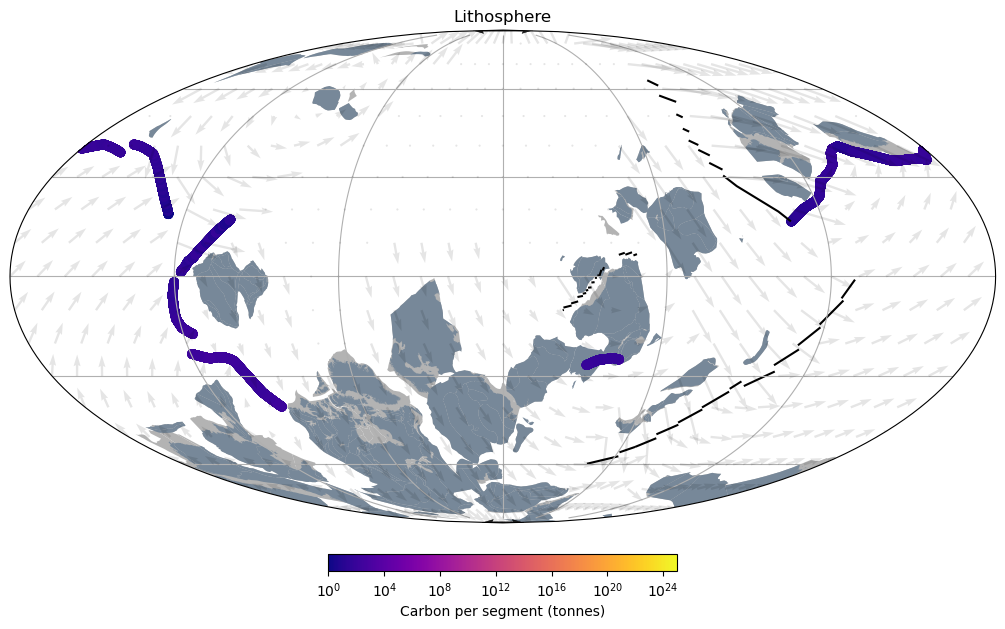

In [11]:
# As an example, plot the subducted lithospheric carbon contribution at max_time
proj = ccrs.Mollweide()

reconstruction_time = reconstruction_times[-1] 
component = "Lithosphere"

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj, title=component)

gplot.time = reconstruction_time
gplot.plot_continents(ax, facecolor='0.7')
gplot.plot_coastlines(ax, facecolor='lightslategrey', edgecolor='None')
gplot.plot_ridges(ax, color='k')
gplot.plot_plate_motion_vectors(ax, color='k', alpha=0.1, zorder=3)

vmin, vmax = 1.0, 1e25
carbon_interp = carbon_interp_tot[-1]
subduction_surface_area = subduction_surface_area_tot[-1] 
subduction_df = dipper.tessellate_slab_dip(reconstruction_time, tessellation_threshold_radians)
sc = ax.scatter(subduction_df.lon, subduction_df.lat, c=carbon_interp*subduction_surface_area, cmap='plasma',
                norm=mcolors.LogNorm(vmin, vmax),transform=ccrs.PlateCarree())

#sc = ax.scatter(subduction_lon, subduction_lat, c=carbon_interp*subduction_surface_area, cmap='plasma',
#                norm=mcolors.LogNorm(vmin, vmax),transform=ccrs.PlateCarree())

ax.gridlines()
fig.colorbar(sc, shrink=0.3, pad=0.05, orientation='horizontal', label='Carbon per segment (tonnes)')

png_filename=output_directory+"/figures/subducted_carbon_{}_snapshot_{:04d}.png".format(component.lower(), reconstruction_time)
fig.savefig(png_filename, dpi=300, bbox_inches='tight')

## Plot rasters of cumulative subducted carbon

### Build the `cumulative_subducted_carbon` array
If `save_output_netcdf` is `True`, total subducted carbon per timestep would have been saved to a netCDF4 grid. 

In the cell below, we loop through time, starting from `max_time` and ending at `min_time` to collect the carbon subducted for each component and quantity. At each time step, we append the current contribution to an array, `cumulative_subducted_carbon` for a given component and quantity. Every timestep we save the current cumulative subducted carbon grid to a netcdf file.


# NOTE:

**To make this process memory-friendly, there are two options for running this cell:**

**1) If memory capacity persists, `joblib` can be used to accumulate grids in parallel**

**2) Otherwise, this can be done in a single thread.**

We can decide whether to use option 1 if we set "accumulate_in_parallel" to True.

In [12]:
accumulate_in_parallel = True

In [13]:
# Define carbon quantities and components
carbon_components = ["Sediment", "Crust", "Lithosphere", "Serpentinite", "Organic_Sediments"]
quantities = ["min", "mean", "max"]

# Define path to the subducted carbon contributions per timestep
subducted_carbon_grid_filename = output_directory+"/subducted_carbon/{}/{}/subducted_carbon_{}_{}.nc"

In [14]:
def accumulate_subducted_carbon(component, reconstruction_time):
    
    # Store cumulative subducted carbon from the grids in a numpy array
    subducted_carbon_components = np.zeros((3, resY, resX))
    
    for i, quantity in enumerate(quantities):
        
        # We are reading numpy masked arrays, so only get the data
        cumulative_carbon_grid = grids.read_netcdf_grid(
            subducted_carbon_grid_filename.format(component, quantity, component.lower(), reconstruction_time)
        ).data
        
        # All zero values are currently NaN. Turn them back to 0. 
        cumulative_carbon_grid_filled = np.nan_to_num(cumulative_carbon_grid)
        cumulative_carbon_grid_filled = grids.fill_raster(cumulative_carbon_grid_filled)
        subducted_carbon_components[i] = cumulative_carbon_grid_filled

    return subducted_carbon_components

In [15]:
if accumulate_in_parallel:
    with Parallel(n_jobs=-3, verbose=1) as parallel:
        cumulative_subducted_carbon = np.zeros((len(carbon_components), 3, resY, resX))

        split_times = np.array_split(reconstruction_times, cpu_count() - 2)

        for times in split_times:
            for c, component in enumerate(carbon_components):

                print("Accumulating {} grids from {}Ma to {}Ma...".format(component, times[0], times[-1]))
                results = parallel(delayed(accumulate_subducted_carbon)(component, time) for time in times)
                print("Done!")
                for subducted_carbon_components in results:
                    cumulative_subducted_carbon[c] += subducted_carbon_components  

Accumulating Sediment grids from 0Ma to 125Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-3)]: Done 126 out of 126 | elapsed:    9.6s finished


Done!
Accumulating Crust grids from 0Ma to 125Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-3)]: Done 126 out of 126 | elapsed:    9.6s finished


Done!
Accumulating Lithosphere grids from 0Ma to 125Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 126 out of 126 | elapsed:    8.9s finished


Done!
Accumulating Serpentinite grids from 0Ma to 125Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-3)]: Done 126 out of 126 | elapsed:    9.5s finished


Done!
Accumulating Organic_Sediments grids from 0Ma to 125Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 126 out of 126 | elapsed:    9.1s finished


Done!
Accumulating Sediment grids from 126Ma to 250Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    8.8s finished


Done!
Accumulating Crust grids from 126Ma to 250Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.4s finished


Done!
Accumulating Lithosphere grids from 126Ma to 250Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.1s finished


Done!
Accumulating Serpentinite grids from 126Ma to 250Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.1s finished


Done!
Accumulating Organic_Sediments grids from 126Ma to 250Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.0s finished


Done!
Accumulating Sediment grids from 251Ma to 375Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    8.8s finished


Done!
Accumulating Crust grids from 251Ma to 375Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.1s finished


Done!
Accumulating Lithosphere grids from 251Ma to 375Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    8.7s finished


Done!
Accumulating Serpentinite grids from 251Ma to 375Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:   10.6s finished


Done!
Accumulating Organic_Sediments grids from 251Ma to 375Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.0s finished


Done!
Accumulating Sediment grids from 376Ma to 500Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.1s finished


Done!
Accumulating Crust grids from 376Ma to 500Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.3s finished


Done!
Accumulating Lithosphere grids from 376Ma to 500Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    8.9s finished


Done!
Accumulating Serpentinite grids from 376Ma to 500Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.9s finished


Done!
Accumulating Organic_Sediments grids from 376Ma to 500Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.4s finished


Done!
Accumulating Sediment grids from 501Ma to 625Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.5s finished


Done!
Accumulating Crust grids from 501Ma to 625Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    8.9s finished


Done!
Accumulating Lithosphere grids from 501Ma to 625Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.0s finished


Done!
Accumulating Serpentinite grids from 501Ma to 625Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.0s finished


Done!
Accumulating Organic_Sediments grids from 501Ma to 625Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.0s finished


Done!
Accumulating Sediment grids from 626Ma to 750Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.1s finished


Done!
Accumulating Crust grids from 626Ma to 750Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.3s finished


Done!
Accumulating Lithosphere grids from 626Ma to 750Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.2s finished


Done!
Accumulating Serpentinite grids from 626Ma to 750Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:   10.1s finished


Done!
Accumulating Organic_Sediments grids from 626Ma to 750Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.6s finished


Done!
Accumulating Sediment grids from 751Ma to 875Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.5s finished


Done!
Accumulating Crust grids from 751Ma to 875Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.5s finished


Done!
Accumulating Lithosphere grids from 751Ma to 875Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.8s finished


Done!
Accumulating Serpentinite grids from 751Ma to 875Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.4s finished


Done!
Accumulating Organic_Sediments grids from 751Ma to 875Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.5s finished


Done!
Accumulating Sediment grids from 876Ma to 1000Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.4s finished


Done!
Accumulating Crust grids from 876Ma to 1000Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.4s finished


Done!
Accumulating Lithosphere grids from 876Ma to 1000Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.8s finished


Done!
Accumulating Serpentinite grids from 876Ma to 1000Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.6s finished


Done!
Accumulating Organic_Sediments grids from 876Ma to 1000Ma...


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.5s finished


Done!


In [16]:
if not accumulate_in_parallel:
    import copy 
    for t, time in enumerate(backward_reconstruction_times):

        for c, component in enumerate(carbon_components):
            for i, quantity in enumerate(quantities):

                # Read the subducted carbon grid made in the parallelised cell above for the current
                # component (c) and quantity (i). 
                cumulative_carbon_grid = grids.read_netcdf_grid(
                    subducted_carbon_grid_filename.format(folder_name, component, quantity, component.lower(), time)
                )
                cumulative_carbon_grid_filled = grids.fill_raster(cumulative_carbon_grid)

                # Append this timestep's contribution to the current cumulative carbon component (c) and quantity (i)
                cumulative_subducted_carbon[c,i] += cumulative_carbon_grid_filled

        # Use 0 --> 1000Ma array for the progress bar
        tools.update_progress(reconstruction_times[t]/max_time)

### Note:
The cumulative subducted carbon array, `cumulative_subducted_carbon`, starts adding contributions from 1000 Ma.


### Total subducted carbon

In [17]:
# remove artefacts from serpentinite grids
cumulative_subducted_carbon[2][1] = ndimage.percentile_filter(cumulative_subducted_carbon[2][1], 1., 5)

In [18]:
# total subducted carbon
import copy

proj = ccrs.Mollweide(central_longitude=160)
reconstruction_time = 0

total_subducted_carbon = np.nansum(cumulative_subducted_carbon, axis=0)[1] # mean


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = total_subducted_carbon*1e6
lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('plasma'))
lognorm_cmap.set_bad((1,1,1), alpha=0)
im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, norm=mcolors.LogNorm(vmin=1e1, vmax=1e3), 
               transform=ccrs.PlateCarree(), interpolation='nearest')

gplot.time = reconstruction_time
# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_coastlines(ax, color='w', alpha=0.25, zorder=2)
gplot.plot_ridges_and_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)

ax.coastlines(zorder=3)
ax.gridlines()
fig.colorbar(im, shrink=0.4, label='Carbon area density (t/m$^2$)', extend='max')

fig.savefig(output_directory+"/figures/cumulative_subducted_carbon_total.png", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/cumulative_subducted_carbon_total.pdf", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/cumulative_subducted_carbon_total.svg", dpi=300, bbox_inches='tight')

### Total subducted carbon (without the contribution of sediment)

In [19]:
# total subducted carbon
import copy

proj = ccrs.Mollweide(central_longitude=160)
reconstruction_time = 0

# Exclude sediment
total_subducted_carbon_without_sediment = np.nansum(cumulative_subducted_carbon[2:,:,:,:], axis=0)[1] # mean


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = total_subducted_carbon_without_sediment*1e6

lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('plasma'))
lognorm_cmap.set_bad((1,1,1), alpha=0)
im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, norm=mcolors.LogNorm(vmin=1e1, vmax=1e3), 
               transform=ccrs.PlateCarree(), interpolation='nearest')

gplot.time = reconstruction_time
# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_coastlines(ax, color='w', alpha=0.25, zorder=2)
gplot.plot_ridges_and_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)

ax.coastlines(zorder=3)
ax.gridlines()
fig.colorbar(im, shrink=0.4, label='Carbon area density (t/m$^2$)', extend='max')

fig.savefig(output_directory+"/figures/cumulative_subducted_carbon_total_no_sediment.png", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/cumulative_subducted_carbon_total_no_sediment.pdf", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/cumulative_subducted_carbon_total_no_sediment.svg", dpi=300, bbox_inches='tight')

### Rasters of each carbon contribution over 1000Ma
In order:

* Sediment
* Organic Sediment
* Serpentinite
* Crust
* Lithosphere

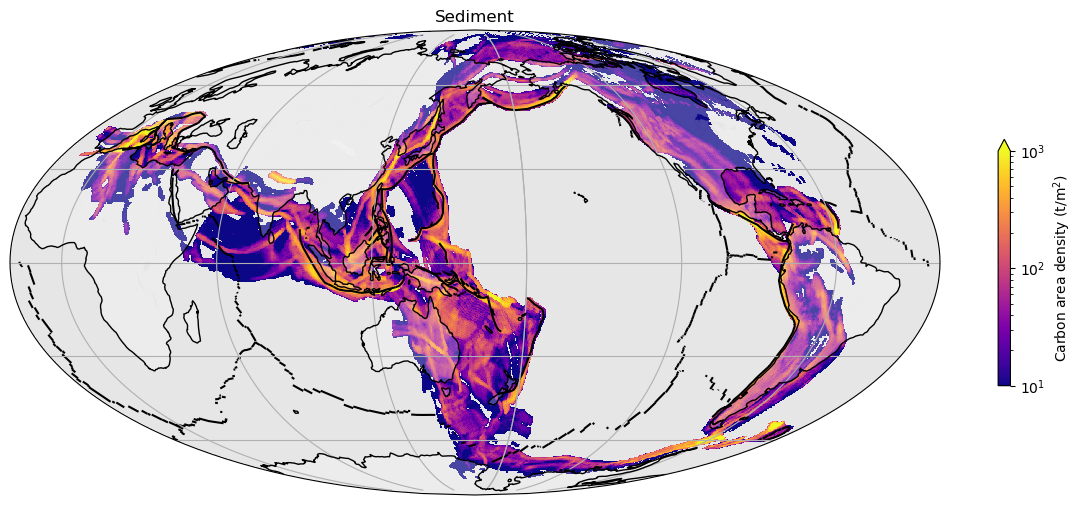

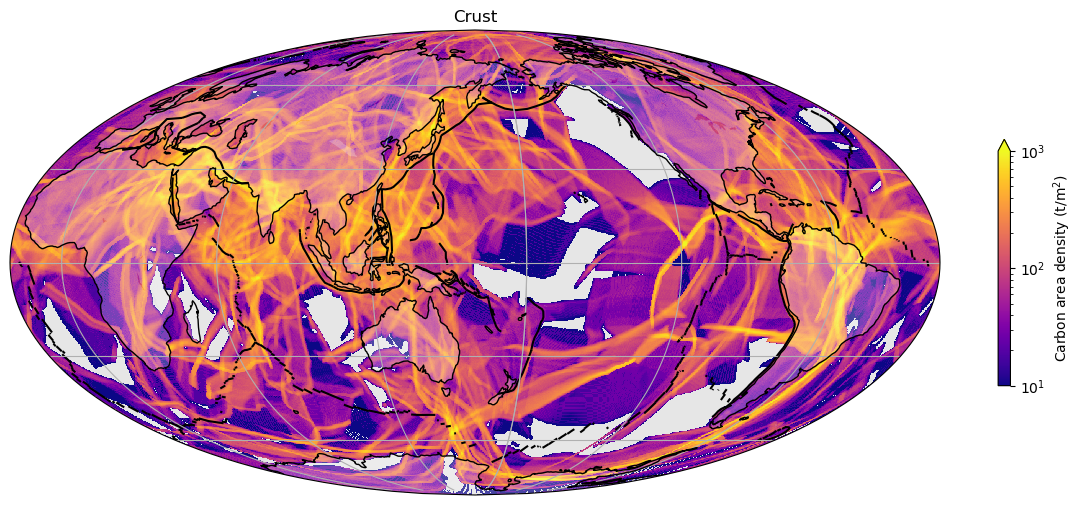

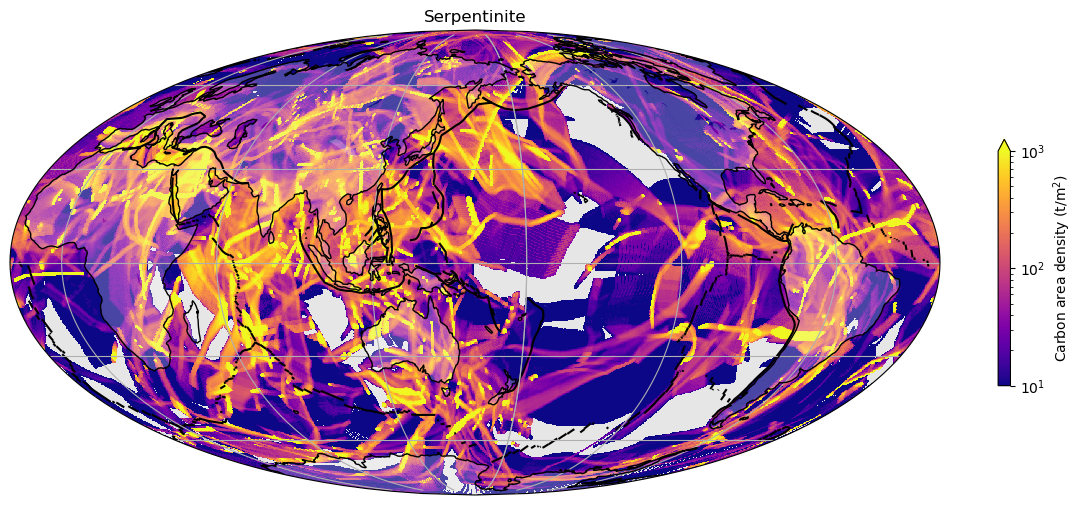

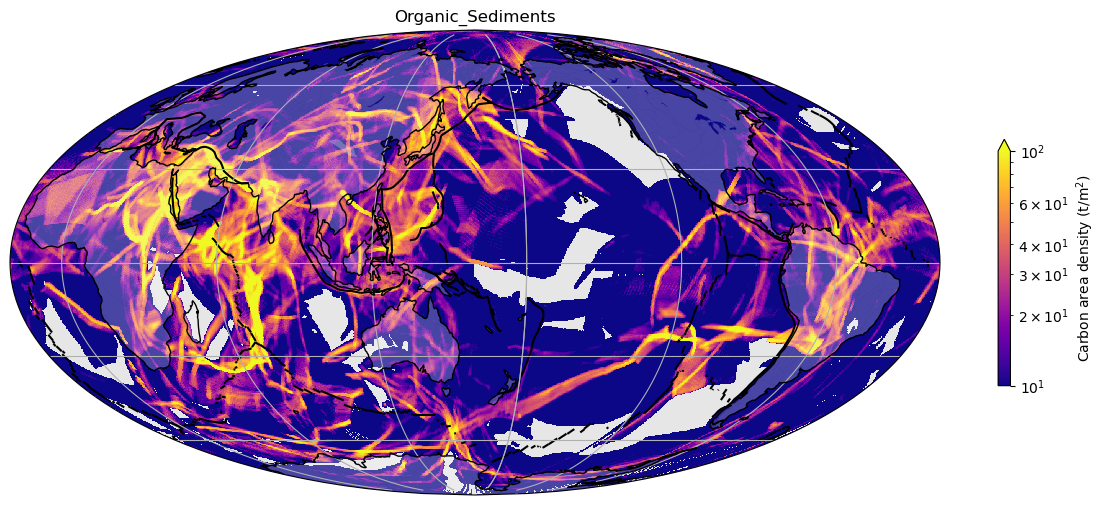

In [20]:
# plot rasters of each carbon contribution
# this relies on a consistent folder structure - don't meddle!
carbon_components = ["Sediment", "Crust", "Lithosphere", "Serpentinite", "Organic_Sediments"]
quantities = ["min", "mean", "max"]

for c, component in enumerate(carbon_components):
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection=proj)
    ax.set_global()

    ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
              transform=ccrs.PlateCarree(), zorder=0)
    
    data = cumulative_subducted_carbon[c,1]*1e6
    lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('plasma'))
    lognorm_cmap.set_bad((1,1,1), alpha=0)
    if component == "Organic_Sediments":
        vmax = 1e2
    else:
        vmax = 1e3
        
    im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, norm=mcolors.LogNorm(vmin=1e1, vmax=vmax), 
                   transform=ccrs.PlateCarree(), interpolation='nearest')

    ax.set_title("{}".format(component))
    gplot.time = reconstruction_time
    # gplot.add_continents(ax, facecolor='0.7', zorder=0)
    gplot.plot_coastlines(ax, facecolor='w', alpha=0.25, zorder=2)
    gplot.plot_ridges(ax, color='k', linewidth=1.5, zorder=2)
    # gplot.add_quiver(ax, color='k', alpha=0.33, zorder=3)
    gplot.plot_trenches(ax, zorder=2)

    ax.coastlines(zorder=3)
    ax.gridlines()
    fig.colorbar(im, shrink=0.4, label='Carbon area density (t/m$^2$)', extend='max')
    
    fig.savefig(output_directory+"/figures/cumulative_subducted_carbon_{}.png".format(component), dpi=300, bbox_inches='tight')
    fig.savefig(output_directory+"/figures/cumulative_subducted_carbon_{}.pdf".format(component), dpi=300, bbox_inches='tight')
    fig.savefig(output_directory+"/figures/cumulative_subducted_carbon_{}.svg".format(component), dpi=300, bbox_inches='tight')

## Prepare the median filter for data smoothing
In this workflow, we use a median filter to smooth data points along the time dimension over a 10 Myr time window.

In [21]:
import scipy.ndimage as sn

# This works for smoothing arrays with a (4,1000,3) shape.
def median_filter_3d(array, time_window):
    smooth_result = np.zeros_like(array)
    for c in range(array.shape[0]):
        for i in range(3):
            smooth_result[c,:,i] = sn.median_filter(array[c,:,i], size=time_window)
            
    return smooth_result

# This works for smoothing arrays with a 2D, i.e. (1000,3) shape.
def median_filter_2d(array, time_window):
    smooth_result = np.zeros_like(array)
    for i in range(array.shape[-1]):
        smooth_result[:,i] = sn.median_filter(array[:,i], size=time_window)
    
    return smooth_result

## Plots of carbon subducted over time

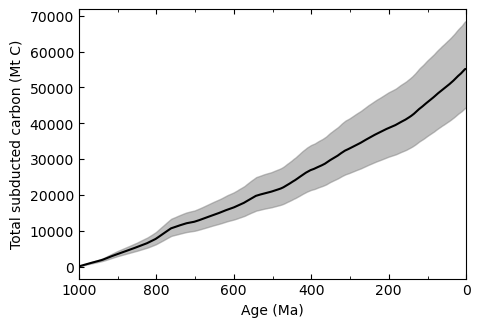

In [23]:
# sum contributions from various carbon reservoirs
carbon_subducted_per_year = (carbon_subducted*1e-6).sum(axis=0) # convert from TC/Ma to Mt C/yr
total_carbon_subducted = np.cumsum(np.flipud(carbon_subducted_per_year), axis=0)[::-1]



# Use a time window of 5Myr - this defines the full width of the Gaussian kernel for one-dim smoothing
time_window = 10 # Myr
smoothed_carbon_subducted = median_filter_3d(carbon_subducted, time_window)
data_out = np.column_stack((
    
    # Sediment
    smoothed_carbon_subducted[0,:,:]*1e-6,
    
    # Crust
    smoothed_carbon_subducted[1,:,:]*1e-6,
    
    # Lithosphere
    smoothed_carbon_subducted[2,:,:]*1e-6,
    
    # Total serpentinite - sum of plate bending and MOR components and median filtered after
    #smoothed_carbon_subducted[3,:,:]*1e-6,
    
    # Serpentinite components (plate bending and slow spreading)
    median_filter_2d(serpentinite_slab_dip*1e-6, time_window) + median_filter_2d(serpentinite_mor*1e-6, time_window),
    # For serpentinite, we have to add subduction components differently...
    
    # Plate bending - note this has no zero-speed points, and no error bars.
    median_filter_2d(serpentinite_slab_dip*1e-6, time_window),
    
    # MOR component straight from carbon grids
    median_filter_2d(serpentinite_mor*1e-6, time_window),
    
    # NOTE THAT since the median filtering is done differently, the sum of plate bending + MOR will not
    # equal the exact CSV column for total serpentinite. 
    
    # Organic sediment
    smoothed_carbon_subducted[4,:,:]*1e-6,
    
    median_filter_2d(carbon_subducted_per_year, time_window),
    median_filter_2d(total_carbon_subducted, time_window)
))

# ADD A NEW COLUMN FOR SERPENTINITE FROM MOR
headers = ['sediments', 'crust', 'lithosphere', 'serpentinite', 'serpentinite_bending', 'serpentinite_mor', 'organic_sediments',
           'total', 'cumulative_subducted', ]
quantiles = ['min', 'mean', 'max']

index = pd.MultiIndex.from_product([headers, quantiles])
carbon_subducted_df = pd.DataFrame(list(data_out), columns = index, index=reconstruction_times) 
carbon_subducted_df.to_csv(output_directory+'/csv/02_subducted_carbon.csv'.format(folder_name))

fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Total subducted carbon (Mt C)', xlim=[max_time,0])

ax.fill_between(reconstruction_times,
                carbon_subducted_df['cumulative_subducted']['min'].to_list(),
                carbon_subducted_df['cumulative_subducted']['max'].to_list(),
                color='0.5', alpha=0.5, label='Uncertainty')
ax.plot(reconstruction_times, carbon_subducted_df['cumulative_subducted']['mean'], 
        'k', label='Mean')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)

fig.savefig(output_directory+"/figures/total_subducted_carbon.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/total_subducted_carbon.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/total_subducted_carbon.png", bbox_inches='tight', dpi=300)

In [24]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Subducted carbon (Mt C/yr)', xlim=[max_time,0])

time_window = 10 #Myr

ax.fill_between(carbon_subducted_df.index,
                carbon_subducted_df['total']['min'].to_numpy(),
                carbon_subducted_df['total']['max'].to_numpy(),
                color='0.5', alpha=0.5, label='Uncertainty')
ax.plot(carbon_subducted_df.index, carbon_subducted_df['total']['mean'].to_numpy(), 'k', label='Mean')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    
fig.savefig(output_directory+"/figures/subducted_carbon_per_year.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/subducted_carbon_per_year.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/subducted_carbon_per_year.png", bbox_inches='tight', dpi=300)

In [25]:
headers = ['sediments', 'crust', 'lithosphere', 'serpentinite', 'organic_sediments',
           'total', 'cumulative_subducted', ]
quantiles = ['min', 'mean', 'max']

carbon_components = ["Sediment", "Crust", "Lithosphere", "Serpentinite", "Organic_Sediments"]

carbon_subducted_df = pd.read_csv(
    "./Outputs/{}/Notebook02/csv/02_subducted_carbon.csv".format(folder_name), 
    index_col=0, header=[0,1]
)
carbon_subducted_df = carbon_subducted_df.reindex(index=reconstruction_times)

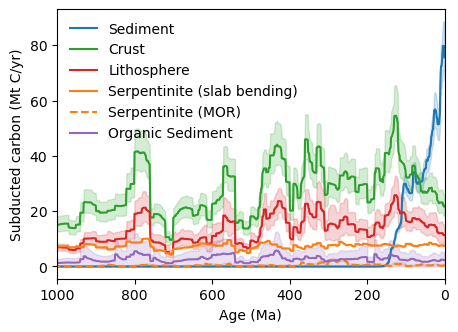

In [26]:
# compare each contribution

fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Subducted carbon (Mt C/yr)', xlim=[max_time,0])

colours = ['C0', 'C2', 'C3', 'C1', 'C4', 'C4']
time_window = 10 #Myr

for c, component in enumerate(carbon_components):

    if component == "Serpentinite":

        ax.fill_between(carbon_subducted_df.index,
                carbon_subducted_df['serpentinite_bending']['min'].to_numpy(),
                carbon_subducted_df['serpentinite_bending']['max'].to_numpy(),
                color='{}'.format(colours[c]), alpha=0.2)
        ax.plot(
            carbon_subducted_df.index, 
            carbon_subducted_df['serpentinite_bending']['mean'].to_numpy(), 
            c="{}".format(colours[c]),
            label='Serpentinite (slab bending)'
        )
        
        ax.fill_between(carbon_subducted_df.index,
                        carbon_subducted_df['serpentinite_mor']['min'].to_numpy(),
                        carbon_subducted_df['serpentinite_mor']['max'].to_numpy(),
                        color='{}'.format(colours[c]), alpha=0.2)
        ax.plot(
            carbon_subducted_df.index, 
            carbon_subducted_df['serpentinite_mor']['mean'].to_numpy(),
            c="{}".format(colours[c]),
            linestyle='--', 
            label='Serpentinite (MOR)'
        )


    else:
        if component == "Organic_Sediments":
            label = "Organic Sediment"
        #elif component == "Sediment":
            #label = "Carbonate Sediment"
        else:
            label = component
            
        if component == "Sediment":
            component = "Sediments"
            
        ax.fill_between(carbon_subducted_df.index,
                        carbon_subducted_df[component.lower()]['min'],
                        carbon_subducted_df[component.lower()]['max'],
                        color='{}'.format(colours[c]), alpha=0.2)
        ax.plot(carbon_subducted_df.index, carbon_subducted_df[component.lower()]['mean'], c="{}".format(colours[c]), label=label)
    
ax.legend(frameon=False)
fig.savefig(output_directory+"/figures/carbon_subducted_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/carbon_subducted_comparison_sameaxes.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/carbon_subducted_comparison_sameaxes.png", bbox_inches='tight', dpi=300)

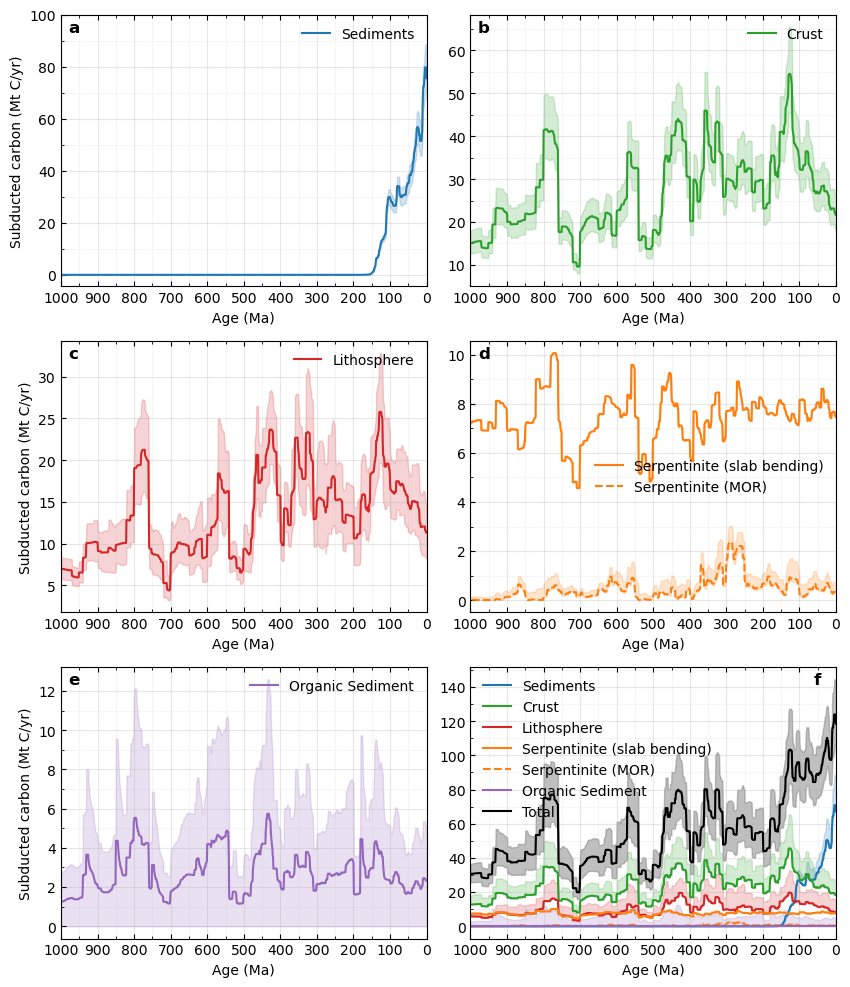

In [28]:
# compare each contribution (separate axes)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10,12))

time_window = 10 #Myr

for c, ax in enumerate([ax1,ax2,ax3,ax4, ax5, ax6]):
    
    if c ==5:
        ax.set_xlim([max_time, min_time])
        
        ax.yaxis.set_ticks(np.arange(0., 151., 10.), minor=True)
        
        for j, component in enumerate(carbon_components):

            if component == "Serpentinite":

                ax.fill_between(carbon_subducted_df.index,
                        carbon_subducted_df['serpentinite_bending']['min'].to_numpy(),
                        carbon_subducted_df['serpentinite_bending']['max'].to_numpy(),
                        color='{}'.format(colours[j]), alpha=0.2)
                ax.plot(
                    carbon_subducted_df.index, 
                    carbon_subducted_df['serpentinite_bending']['mean'].to_numpy(), 
                    c="{}".format(colours[j]),
                    label='Serpentinite (slab bending)'
                )

                ax.fill_between(carbon_subducted_df.index,
                                carbon_subducted_df['serpentinite_mor']['min'].to_numpy(),
                                carbon_subducted_df['serpentinite_mor']['max'].to_numpy(),
                                color='{}'.format(colours[j]), alpha=0.2)
                ax.plot(
                    carbon_subducted_df.index, 
                    carbon_subducted_df['serpentinite_mor']['mean'].to_numpy(),
                    c="{}".format(colours[j]),
                    linestyle='--', 
                    label='Serpentinite (MOR)'
                )
            else:
                
                if component == "Organic_Sediments":
                    label = "Organic Sediment"
                #elif component == "Sediment":
                    #label = "Carbonate Sediment"
                else:
                    label = carbon_components[j]
                    
                if component == "Sediment":
                    component = "Sediments"
                
                ax.fill_between(carbon_subducted_df.index,
                                carbon_subducted_df[component.lower()]['min'].to_numpy(),
                                carbon_subducted_df[component.lower()]['max'].to_numpy(),
                                color='{}'.format(colours[j]), alpha=0.2)
                ax.plot(carbon_subducted_df.index, carbon_subducted_df[component.lower()]['min'].to_numpy(), c="{}".format(colours[j]), label=label)
        
        ax.fill_between(carbon_subducted_df.index,
                        carbon_subducted_df['total']['min'].to_numpy(),
                        carbon_subducted_df['total']['max'].to_numpy(),
                        color='0.5', alpha=0.5,)
        ax.plot(carbon_subducted_df.index, carbon_subducted_df['total']['mean'].to_numpy(), 'k', label='Total')
        ax.set_xlim([max_time, min_time])
        
        ax.legend(frameon=False)
        ax.set_xlabel('Age (Ma)')
        continue

        
    if carbon_components[c] == "Serpentinite":

        ax.plot(
            carbon_subducted_df.index, 
            #carbon_subducted_df['serpentinite']['mean'].to_numpy() - carbon_subducted_df['serpentinite_mor']['mean'].to_numpy(), 
            carbon_subducted_df['serpentinite_bending']['mean'].to_numpy(),
            c="{}".format(colours[c]),
            label='Serpentinite (slab bending)'
        )
        
        ax.fill_between(carbon_subducted_df.index,
                        #carbon_subducted_df['serpentinite']['min'].to_numpy() - carbon_subducted_df['serpentinite_mor']['min'].to_numpy(),
                        #carbon_subducted_df['serpentinite']['max'].to_numpy() - carbon_subducted_df['serpentinite_mor']['max'].to_numpy(),
                        carbon_subducted_df['serpentinite_bending']['min'].to_numpy(),
                        carbon_subducted_df['serpentinite_bending']['max'].to_numpy(),
                        color='{}'.format(colours[c]), alpha=0.2)
        
        

        ax.fill_between(carbon_subducted_df.index,
                        carbon_subducted_df['serpentinite_mor']['min'].to_numpy(),
                        carbon_subducted_df['serpentinite_mor']['max'].to_numpy(),
                        color='{}'.format(colours[c]), alpha=0.2)
        ax.plot(
            carbon_subducted_df.index, 
            carbon_subducted_df['serpentinite_mor']['mean'].to_numpy(), 
            c="{}".format(colours[c]),linestyle='--', label='Serpentinite (MOR)'
        )


    else:
        if carbon_components[c] == "Organic_Sediments":
            label = "Organic Sediment"
        #elif carbon_components[c] == "Sediment":
            #label = "Carbonate Sediment"
        else:
            label = carbon_components[c]
            
        if carbon_components[c] == "Sediment":
            carbon_components[c] = "Sediments"
            
        #ax.fill_between(carbon_subducted_df.index,
        #                sn.median_filter(carbon_subducted[c,:,0]*1e-6, size=time_window),
        #                sn.median_filter(carbon_subducted[c,:,2]*1e-6, size=time_window),
        #                color='{}'.format(colours[c]), alpha=0.2)
        #ax.plot(carbon_subducted_df.index, sn.median_filter(carbon_subducted[c,:,1]*1e-6, size=time_window), c="{}".format(colours[c]),
        #        label=label)
       
        ax.fill_between(carbon_subducted_df.index,
                        carbon_subducted_df[carbon_components[c].lower()]['min'],
                        carbon_subducted_df[carbon_components[c].lower()]['max'],
                        color='{}'.format(colours[c]), alpha=0.2)
        ax.plot(carbon_subducted_df.index, carbon_subducted_df[carbon_components[c].lower()]['mean'], c="{}".format(colours[c]), label=label)
    
    ax.set_xlim(max_time,0)
    ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Subducted carbon (Mt C/yr)')
    ax.legend(frameon=False)
    plt.subplots_adjust(hspace=0.2)
    
    
img_id = ["a","b","c","d","e","f"]
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5, ax6]):
    
    if i == 5:
        ax.annotate('{}'.format(img_id[i]), xy=(0.94, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='left', verticalalignment='top')
    else:
        ax.annotate('{}'.format(img_id[i]), xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                    horizontalalignment='left', verticalalignment='top')
    
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    
    ax.xaxis.set_ticks(np.arange(0., 1001., 50.), minor=True)
    ax.xaxis.set_ticks(np.arange(0., 1001., 100.), major=True)
    
    if not i % 2 == 0:
        ax.set_ylabel(None)
        
        
        
    if i == 0:
        ax.yaxis.set_ticks(np.arange(0., 101., 10.), minor=True)
    if i == 1:
        ax.yaxis.set_ticks(np.arange(5., 70., 5.), minor=True)
    if i == 3:
        ax.yaxis.set_ticks(np.arange(0., 11., 1.), minor=True)
    if i == 4:
        ax.yaxis.set_ticks(np.arange(0., 12., 1.), minor=True)
        
    ax.grid(alpha=0.1, which='minor')
    ax.grid(alpha=0.3, which='major')
        
plt.subplots_adjust(hspace=0.2, wspace=0.12)

fig.savefig(output_directory+"/figures/carbon_subducted_comparison.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/carbon_subducted_comparison.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/carbon_subducted_comparison.png", bbox_inches='tight', dpi=300)

## Plot of plate influx

Now we know the subduction flux, we can compute plate influx.

$\dot{C}_{\mathrm{inplate}} = \dot{C}_{\mathrm{plate}} + \dot{C}_{\mathrm{mantle}}$

where:

* $\dot{C}_{\mathrm{inplate}}$ is the plate influx;
* $\dot{C}_{\mathrm{plate}}$ is the plate influx minus plate outflux (the difference in plate storage) between times t and t+1. We calculate this using the gradient operator.
* $\dot{C}_{\mathrm{mantle}}$ is the plate outflux / subduction flux from each plate reservoir between times t and t+1.

In this workflow, we perform **double median-filtering** for $\dot{C}_{\mathrm{plate}}$ - first, we filter the carbon in plate, then its gradient.

In [29]:
#carbon_components = ["Sediment", "Crust", "Lithosphere", "Serpentinite", "Organic_Sediments"]

time_window = 10 # Myr

# Smooth values of carbon read directly from carbon grids (Mt C/m^2/yr) multiplied by grid cell areas (m^2),
# so this value is in Mt C/yr
smooth_carbon_in_plate = median_filter_3d(
        carbon_in_plate[:,::-1,:],
        time_window
    )

# Calculate the first-order time gradient of the median-smoothed carbon in plate array, and smooth this array
carbon_plate_influx_without_subduction = median_filter_3d(
    np.gradient(smooth_carbon_in_plate, 1.0, axis=1)[:,::-1,:],
    time_window
)

carbon_plate_influx_without_subduction_clipped = np.clip(carbon_plate_influx_without_subduction, 0., None)

# Add smoothed subducted carbon (values directly from carbon_in_plate interpolated at subduction zones, multiplied by
# subduction zone area: subduction convergence rate (m/yr) * trench length (m))
carbon_plate_influx = carbon_plate_influx_without_subduction_clipped + median_filter_3d(carbon_subducted, time_window,)

# Sum across all 4 components to obtain a total min, mean and max plate influx through time. 
total_carbon_plate_influx = carbon_plate_influx.sum(axis=0)

# Prepare smoothed arrays to be saved to a csv
data_out = np.column_stack((
    
    # Sediment
    carbon_plate_influx[0,:,:]*1e-6,
    
    # Crust
    carbon_plate_influx[1,:,:]*1e-6,
    
    # Lithosphere
    carbon_plate_influx[2,:,:]*1e-6,
    
    # Just add a column for total serpentinite
    np.clip(carbon_plate_influx_without_subduction[3,:,:]*1e-6 + median_filter_2d(serpentinite_mor, time_window)*1e-6 +median_filter_2d(serpentinite_slab_dip, time_window)*1e-6, 0., None),
    
    # For serpentinite, we have to add subduction components differently...
    # Plate bending
    np.clip(median_filter_2d(serpentinite_slab_dip, time_window)*1e-6, 0., None),
    
    # MOR component
    np.clip(carbon_plate_influx_without_subduction[3,:,:]*1e-6 + median_filter_2d(serpentinite_mor, time_window)*1e-6, 0., None),

    # Organic sediment
    carbon_plate_influx[4,:,:]*1e-6,
    
    # Total
    total_carbon_plate_influx*1e-6
))

headers = ['sediments', 'crust', 'lithosphere', 'serpentinite_total', 'serpentinite_bending', 'serpentinite_mor', 'organic_sediments',
           'total_influx',]
quantiles = ['min', 'mean', 'max']

index = pd.MultiIndex.from_product([headers, quantiles])

plate_influx_df = pd.DataFrame(list(data_out), columns = index, index=reconstruction_times) 
plate_influx_df.to_csv(output_directory+'/csv/02_plate_influx.csv'.format(folder_name), index_label='age')

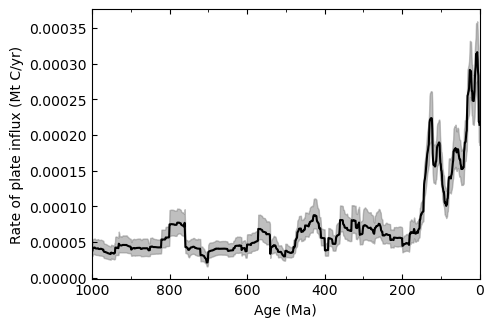

In [30]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Rate of plate influx (Mt C/yr)', xlim=[max_time,0])

ax.fill_between(plate_influx_df.index,
                plate_influx_df['total_influx']['min'].to_numpy()*1e-6,
                plate_influx_df['total_influx']['max'].to_numpy()*1e-6,
                color='0.5', alpha=0.5, label='Uncertainty')

ax.plot(plate_influx_df.index, plate_influx_df['total_influx']['mean'].to_numpy()*1e-6, 'k', label='Mean')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    
fig.savefig(output_directory+"/figures/plate_influx.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/plate_influx.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/plate_influx.png", bbox_inches='tight', dpi=300)

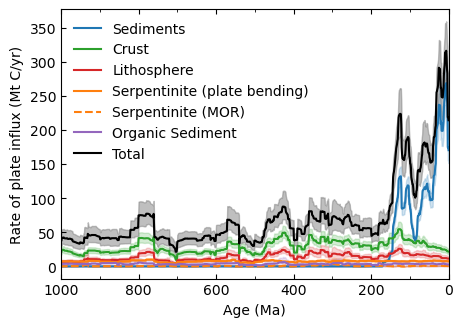

In [31]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Rate of plate influx (Mt C/yr)', xlim=[max_time,0])
# ax.set_yscale('log')


for c, component in enumerate(carbon_components):
    ax.fill_between(plate_influx_df.index,
                    carbon_plate_influx[c,:,0]*1e-6,
                    carbon_plate_influx[c,:,2]*1e-6,
                    color='{}'.format(colours[c]), alpha=0.2)
    
    if carbon_components[c] == "Serpentinite":

        label = 'Serpentinite (plate bending)'
        ax.plot(plate_influx_df.index, plate_influx_df['serpentinite_bending']['mean'].to_numpy(), c="{}".format(colours[c]), label=label)

        ax.fill_between(plate_influx_df.index,
                    plate_influx_df['serpentinite_bending']['min'].to_numpy(),
                    plate_influx_df['serpentinite_bending']['max'].to_numpy(),
                    color="{}".format(colours[c]), alpha=0.5)

        label = 'Serpentinite (MOR)'
        ax.plot(plate_influx_df.index, plate_influx_df['serpentinite_mor']['mean'].to_numpy(), 
                color="{}".format(colours[c]), linestyle='--', label=label)

        ax.fill_between(plate_influx_df.index,
                    plate_influx_df['serpentinite_mor']['min'].to_numpy(),
                    plate_influx_df['serpentinite_mor']['max'].to_numpy(),
                     color="{}".format(colours[c]), alpha=0.5)
    else:

        if component == "Organic_Sediments":
            label = "Organic Sediment"
        #elif component == "Sediment":
            #label = "Carbonate Sediment"
        else:
            label = str(carbon_components[c])
            
        ax.plot(plate_influx_df.index, carbon_plate_influx[c,:,1]*1e-6, c="{}".format(colours[c]), label=label)
    
    
ax.fill_between(plate_influx_df.index,
                total_carbon_plate_influx[:,0]*1e-6,
                total_carbon_plate_influx[:,2]*1e-6,
                color='0.5', alpha=0.5)
ax.plot(plate_influx_df.index, total_carbon_plate_influx[:,1]*1e-6, 'k', label='Total')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
ax.legend(frameon=False)


fig.savefig(output_directory+"/figures/plate_influx_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/plate_influx_comparison_sameaxes.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/plate_influx_comparison_sameaxes.png", bbox_inches='tight', dpi=300)

In [32]:
# plate influx - 10Myr median filtered
plate_influx = pd.read_csv('./Outputs/{}/Notebook02/csv/02_plate_influx.csv'.format(folder_name), index_col=0, header=[0,1])
plate_influx = plate_influx.reindex(index=reconstruction_times)
sediments_influx    = plate_influx.loc[:, (['sediments'], ['min', 'mean', 'max'])].to_numpy()
serpentinite_influx = plate_influx.loc[:, (['serpentinite_total'], ['min', 'mean', 'max'])].to_numpy()
crust_influx        = plate_influx.loc[:, (['crust'], ['min', 'mean', 'max'])].to_numpy()
upper_plate_influx  = sediments_influx + serpentinite_influx + crust_influx
upper_plate_influx_no_sediment = serpentinite_influx + crust_influx

plate_influx_df['serpentinite_bending']['mean'].to_numpy()
plate_influx_df['serpentinite_mor']['mean'].to_numpy()


array([0.62504699, 0.62504699, 0.62504699, ..., 0.12974799, 0.0892602 ,
       0.0892602 ])

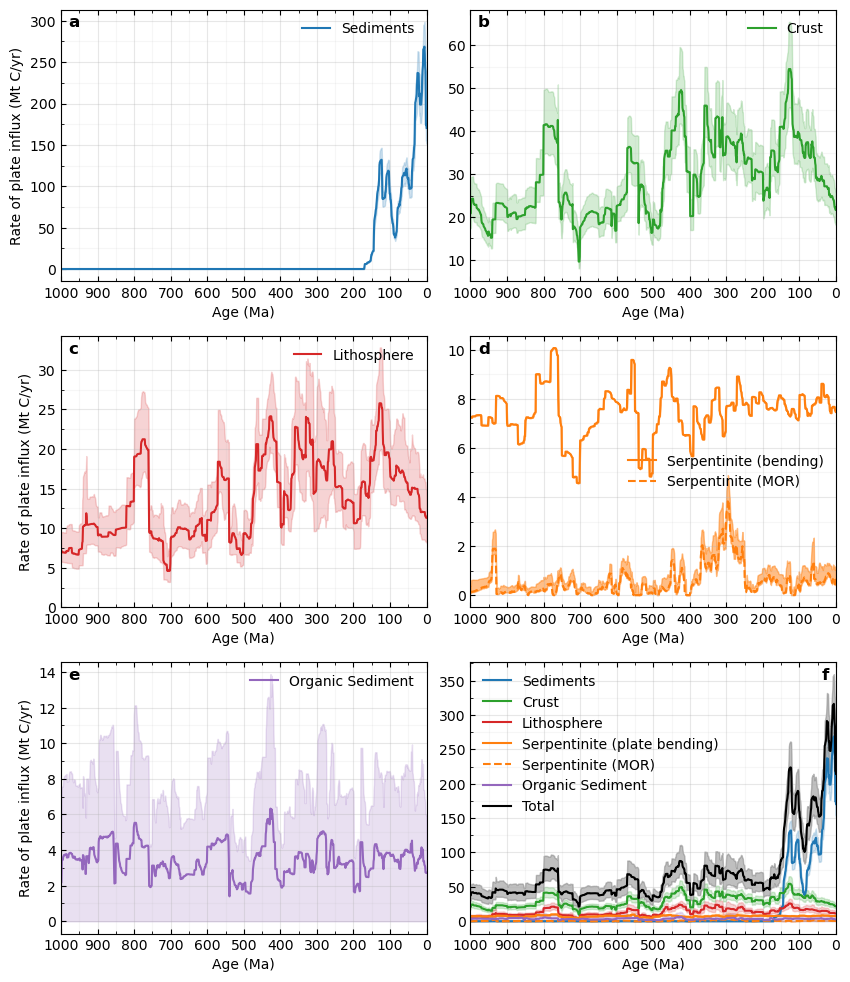

In [34]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10,12))

for c, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    
    if c == 5:
        for j, component in enumerate(carbon_components):
            ax.fill_between(plate_influx_df.index,
                            carbon_plate_influx[j,:,0]*1e-6,
                            carbon_plate_influx[j,:,2]*1e-6,
                            color='{}'.format(colours[j]), alpha=0.2)

            if carbon_components[j] == "Serpentinite":

                label = 'Serpentinite (plate bending)'
                ax.plot(plate_influx_df.index, plate_influx_df['serpentinite_bending']['mean'].to_numpy(), c="{}".format(colours[j]), label=label)

                ax.fill_between(plate_influx_df.index,
                            plate_influx_df['serpentinite_bending']['min'].to_numpy(),
                            plate_influx_df['serpentinite_bending']['max'].to_numpy(),
                            color="{}".format(colours[j]), alpha=0.5)

                label = 'Serpentinite (MOR)'
                ax.plot(plate_influx_df.index, plate_influx_df['serpentinite_mor']['mean'].to_numpy(), 
                        color="{}".format(colours[j]), linestyle='--', label=label)

                ax.fill_between(plate_influx_df.index,
                            plate_influx_df['serpentinite_mor']['min'].to_numpy(),
                            plate_influx_df['serpentinite_mor']['max'].to_numpy(),
                             color="{}".format(colours[j]), alpha=0.5)
            else:

                if component == "Organic_Sediments":
                    label = "Organic Sediment"
                #elif component == "Sediment":
                    #label = "Carbonate Sediment"
                else:
                    label = str(carbon_components[j])
            
                ax.plot(plate_influx_df.index, carbon_plate_influx[j,:,1]*1e-6, c="{}".format(colours[j]), label=label)


        ax.fill_between(plate_influx_df.index,
                        total_carbon_plate_influx[:,0]*1e-6,
                        total_carbon_plate_influx[:,2]*1e-6,
                        color='0.5', alpha=0.5)
        ax.plot(plate_influx_df.index, total_carbon_plate_influx[:,1]*1e-6, 'k', label='Total')
        ax.set_xlim([max_time, min_time])
        ax.legend(frameon=False)
        ax.set_xlabel('Age (Ma)')
        continue

    if carbon_components[c] == "Serpentinite":
        
        label = 'Serpentinite (plate bending)'
        ax.plot(plate_influx_df.index, plate_influx_df['serpentinite_bending']['mean'].to_numpy(), c="{}".format(colours[c]), label='Serpentinite (bending)')

        ax.fill_between(plate_influx_df.index,
                    plate_influx_df['serpentinite_bending']['min'].to_numpy(),
                    plate_influx_df['serpentinite_bending']['max'].to_numpy(),
                    color="{}".format(colours[c]), alpha=0.5)

        label = 'Serpentinite (MOR)'
        ax.plot(plate_influx_df.index, plate_influx_df['serpentinite_mor']['mean'].to_numpy(), 
                c="{}".format(colours[c]), linestyle='--', label=label)

        ax.fill_between(plate_influx_df.index,
                    plate_influx_df['serpentinite_mor']['min'].to_numpy(),
                    plate_influx_df['serpentinite_mor']['max'].to_numpy(),
                    color="{}".format(colours[c]), alpha=0.5)
        
    else:
        if carbon_components[c] == "Organic_Sediments":
            label = "Organic Sediment"
        #elif carbon_components[c] == "Sediment":
            #label = "Carbonate Sediment"
        else:
            label = carbon_components[c]
            
        ax.plot(plate_influx_df.index, carbon_plate_influx[c,:,1]*1e-6, c="{}".format(colours[c]), label=label)
        ax.fill_between(plate_influx_df.index,
                carbon_plate_influx[c,:,0]*1e-6,
                carbon_plate_influx[c,:,2]*1e-6,
                color='{}'.format(colours[c]), alpha=0.2)
    
    ax.set_xlim(max_time,0)
    ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Rate of plate influx (Mt C/yr)')
    ax.legend(frameon=False)
    plt.subplots_adjust(hspace=0.2)
    
    
img_id = ["a","b","c","d","e","f"]
for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    
    if i == 5:
        ax.annotate('{}'.format(img_id[i]), xy=(0.96, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='left', verticalalignment='top')
    else:
        ax.annotate('{}'.format(img_id[i]), xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                    horizontalalignment='left', verticalalignment='top')
    
    ax.set_xlabel('Age (Ma)')
    ax.legend(frameon=False)
    ax.set_xlim(max_time,0)
    ax.xaxis.set_minor_locator(MultipleLocator(100))
    ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
    if not i % 2 == 0:
        ax.set_ylabel(None)
        
    ax.xaxis.set_ticks(np.arange(0., 1001., 50.), minor=True)
    ax.xaxis.set_ticks(np.arange(0., 1001., 100.), major=True)
        
            
    if i == 0:
        ax.yaxis.set_ticks(np.arange(0., 300., 25.), minor=True)
    if i == 1:
        ax.yaxis.set_ticks(np.arange(5., 60., 5.), minor=True)
    if i == 2:
        ax.yaxis.set_ticks(np.arange(0., 31., 2.5), minor=True)
    if i == 3:
        ax.yaxis.set_ticks(np.arange(0., 11., 1.), minor=True)
    if i == 4:
        ax.yaxis.set_ticks(np.arange(0., 13., 1.), minor=True)
    if i == 5:
        ax.yaxis.set_ticks(np.arange(0., 376., 25.), minor=True)
        
    ax.grid(alpha=0.1, which='minor')
    ax.grid(alpha=0.3, which='major')

plt.subplots_adjust(hspace=0.2, wspace=0.12)


fig.savefig(output_directory+"/figures/plate_influx_comparison.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/plate_influx_comparison.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"/figures/plate_influx_comparison.png", bbox_inches='tight', dpi=300)